modifying neural net

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from time import sleep


In [6]:
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
cmap_light = ListedColormap(["#FFBBBB", "#BBFFBB", "#BBBBFF"])


Activation and Helper functions

In [9]:
#H means hypothesis
def linear(H):
  return H

def ReLu(H):
  return H*(H>0)

def sigmoid(H):
  return 1/(1+np.exp(-H))


def softmax(H):
  eH = np.exp(H)
  return eH/eH.sum(axis = 1, keepdims = True)  


def cross_entropy(Y, P_hat):
    return -(1/len(Y))*np.sum(Y*np.log(P_hat))

def one_hot_encode(y):
    N=len(y)
    K = len(set(y))
    Y=np.zeros((N,K))
    
    for i in range(N):
        Y[i,y[i]]=1
        
    return Y
    
def accuracy(y, y_hat): 
    return np.mean(y==y_hat)

def OLS(Y,Y_hat): 
    return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

def R2(y,y_hat):  
    return 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)  



def derivatives(Z,a): #a is activation function, Z is result of layers
#give me the derivaties of Z 
  if a == linear:
    return 1

  elif a == sigmoid:
    return Z*(1-Z)
  
  elif a == np.tanh:
    return 1 - Z*Z

  elif a == ReLu:
    return (Z>0).astype(int)

  else:
    return ValueError("unknown activation function")










Neural Net Class

In [19]:
class DANN():

  def __init__(self,architecture,activations = None, mode = 0):
    self.mode = mode
    self.architecture = architecture
    self.activations = activations
    #L is the final layer
    self.L = len(architecture)+1
  
  def fit(self, X, y, eta =1e-3, epochs=1e3,show_curve=False):
    epochs = int(epochs)
    if self.mode:
      Y = y
    else:
      Y = one_hot_encode(y)

      N,D = X.shape

      K = Y.shape[1]

      #Weights and Bias initalization(random)
      #generate empty object to put our wieghts in depending on size 
      self.W = {l:np.random.randn(M[0],M[1]) for l,M in enumerate(zip(([D]+self.architecture),(self.architecture + [K])),1)}
      self.b = {l: np.random.randn(M) for l,M in enumerate(self.architecture +[K],1)}

      #Activation function loding 

      if self.activations is None:
        self.a = {l: ReLu for l in range(1,self.L)}
      else:
        #if a is not empty then take every single one and assign 1 from the activations list for each value layer from 1 to l
        self.a = {l: act for l,act in enumerate(self.activations, 1)}


      #mode set

      if self.mode:
        #output layer
        self.a[self.L] = linear
      else:
        self.a[self.L] = softmax
      
      J = np.zeros(epochs)

      #gradient descent
      for epoch in range(epochs):
        self.forward(X)
        if self.mode:
          J[epoch]=OLS(Y,self.Z[self.L])
        else:
          J[epoch] = cross_entropy(Y,self.Z[self.L])
        #differential equation of H  
        dH = (1/N)*(self.Z[self.L]-Y)
        #update rules for weight and bias  
        for l in sorted(self.W.keys(),reverse=True):
          dW = self.Z[l -1].T@dH
          db = dH.sum(axis=0)
          self.W[l] -= eta*dW
          self.b[l] -= eta*db
          if l > 1:
            dZ = dH@self.W[l].T
            dH = dZ*derivatives(self.Z[l-1],self.a[l-1])

    #show training curve  
    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")
      plt.show()

  
  
  def forward(self,X):
    self.Z = {0:X}

    for l in sorted(self.W.keys()):
      self.Z[l] =self.a[l](self.Z[l-1]@self.W[l] + self.b[l])

  def predict(self,X):
    self.forward(X)

    if self.mode:
      return self.Z[self.L]
    else:
      return self.Z[self.L].argmax(axis=1)
    

    







         






    










    




In [20]:
def main():
  #number of dimensions and classes 
    D = 2
    K = 3
    N = int(K*1e3)

    #make up data
    X0 = np.random.randn((N//K),D) + np.array([2,2])
    X1 = np.random.randn((N//K),D) + np.array([0,-2])
    X2 = np.random.randn((N//K),D) + np.array([-2,2])
    X = np.vstack((X0,X1,X2))
    y = np.array([0]*(N//K) + [1]*(N//K) + [2]*(N//K))

    #fit and predict the data
    myAnn = DANN([8,8,8],[ReLu,np.tanh,np.tanh])
    myAnn.fit(X,y,eta=3e-2, epochs=2e3, show_curve=True) #show training curve true
    y_hat = myAnn.predict(X)
    #print accuracy
    print(f"Training Accuracy: {accuracy(y,y_hat):0.4f}")
    #draw graphs      
    x1 = np.linspace(X[:,0].min() -1, X[:,0].max(), 1000)
    x2 = np.linspace(X[:,1].min() -1, X[:,1].max(), 1000)
    #preduct the prediction and draw graphs
    xx1,xx2 = np.meshgrid(x1,x2)
    Z = myAnn.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(*xx1.shape)
    #draw graphs
    plt.figure()
    plt.scatter(X[:,0],X[:,1],c=y, cmap=cmap_bold)
    plt.title(" Data ")
    
    plt.figure()
    plt.scatter(X[:,0],X[:,1],c=y_hat, cmap=cmap_bold)
    plt.title(" Prediction ")
    plt.pcolormesh(xx1,xx2,Z, cmap=cmap_light)
    plt.show()

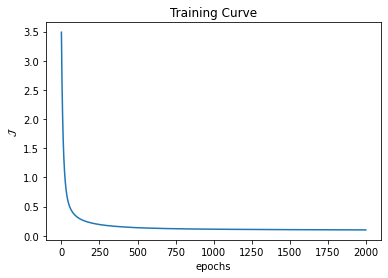

Training Accuracy: 0.9683


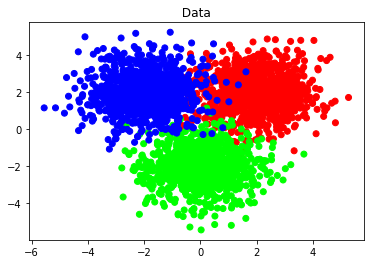

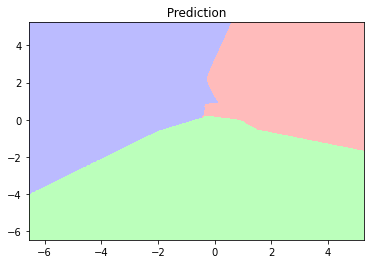

In [21]:
if __name__ == "__main__":
  main()